# Lecture 4: Programming a quantum algorithm with pyQuil

This notebook is part of the course [CS 269Q: Quantum Computer Programming](https://cs269q.stanford.edu/), offered at Stanford in the Spring of 2019.

It was created by [Peter Karalekas](https://github.com/karalekas), Quantum Software Engineer at [Rigetti Computing](https://rigetti.com/) and Guest Lecturer for the course.

## Introduction

In this lecture, we will build up the mathematical and software tools required to implement our very first quantum algorithm—[Deutsch's algorithm](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm)—using [pyQuil](https://github.com/rigetti/pyquil) and the [QVM](https://github.com/rigetti/qvm) to step through the protocol and inspect the wavefunction. The three things that we will need to understand before we get to the algorithm are:

- [Part I: The wavefunction & quantum circuits](#wavefunction)
- [Part II: Classical logic & function evaluation](#classical-logic)
- [Part III: Quantum parallelism](#parallelism)

Once we've worked through these concepts, we will then conclude with [Part IV: Deutsch's algorithm](#deutsch).

## Setup

If you are running this from [Binder](https://mybinder.org/v2/gh/karalekas/stanford-cs269q/master?urlpath=lab/tree/Lecture4.ipynb), then you don't need to worry about any setup, but I do recommend that you click on "Kernel > Restart & Clear Output" before running through the notebook.

If you've cloned this notebook locally, you'll need to get a QVM server running and install all the notebook dependencies. To run a QVM server on the standard port (5000), the command is simply `qvm -S`. This assumes that you have a correctly configured `~/.forest_config` file with `qvm_address` equal to `http://localhost:5000`. As for dependencies, this notebook uses `python3.6` and requires `pyquil`, `matplotlib`, and `qutip` to run. The `qutip` package in turn requires preinstalled `cython`, `numpy`, and `scipy`.

<a id='wavefunction'></a>

## Part I: The wavefunction & quantum circuits

We begin by doing our standard imports. We will explain below what each of these things means.

In [1]:
from pyquil import Program
from pyquil.api import QVMConnection
from pyquil.gates import I, H, X, CNOT, MEASURE

### Gross Plotting Code

Understanding this code is not important at all for this lecture. I will eventually clean it up and add the useful bits to the mainline codebase for pyquil.

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyquil.wavefunction import get_bitstring_from_index, Wavefunction
from qutip import Bloch, basis

def plot_bloch(wf: Wavefunction, axes=None, fig=None):
    if len(wf.amplitudes) > 2:
        raise ValueError('Bloch sphere plotting only works with 1Q')
    state = (wf.amplitudes[0] * basis(2,0) + wf.amplitudes[1] * basis(2,1))
    b = Bloch(fig=fig, axes=axes)
    b.add_states(state)
    b.render(fig=fig, axes=axes)

def plot_probabilities(wf: Wavefunction, axes=None, qubit_subset=None):
    prob_dict = wf.get_outcome_probs()
    if qubit_subset:
        sub_dict = {}
        qubit_num = len(wf)
        for i in qubit_subset:
            if i > (2**qubit_num - 1):
                raise IndexError("Index {} too large for {} qubits.".format(i, qubit_num))
            else:
                sub_dict[get_bitstring_from_index(i, qubit_num)] = prob_dict[get_bitstring_from_index(i, qubit_num)]
        prob_dict = sub_dict
    axes.set_ylim(0, 1)
    axes.set_ylabel('Outcome probability', fontsize=16)
    axes.set_xlabel('Bitstring outcome', fontsize=16)
    axes.bar(range(len(prob_dict)), prob_dict.values(), align='center', color='#6CAFB7')
    axes.set_xticks(range(len(prob_dict)))
    axes.set_xticklabels(prob_dict.keys(), fontsize=14)
    
def plot_wf(wf: Wavefunction, wf0=None, wf1=None, bitstring_subset=None):
    if len(wf.amplitudes) == 2:
        fig = plt.figure(figsize=(12, 6))
        wf_ax = fig.add_subplot(121)
        plot_probabilities(wf, axes=wf_ax, qubit_subset=bitstring_subset)
        bloch_ax = fig.add_subplot(122, projection='3d')
        plot_bloch(wf, axes=bloch_ax, fig=fig)
        fig.suptitle(f'$|\psi>$ = {wf}\n', fontsize=16)
    elif len(wf.amplitudes) == 4 and wf0 is not None and wf1 is not None:
        fig = plt.figure(figsize=(18, 6))
        wf_ax = fig.add_subplot(131)
        plot_probabilities(wf, axes=wf_ax, qubit_subset=bitstring_subset)
        bloch1_ax = fig.add_subplot(132, projection='3d')
        plot_bloch(wf1, axes=bloch1_ax, fig=fig)
        bloch0_ax = fig.add_subplot(133, projection='3d')
        plot_bloch(wf0, axes=bloch0_ax, fig=fig)
        fig.suptitle(f'$|\psi>$ = {wf}\n', fontsize=18)
    else:
        fig = plt.figure(figsize=(6, 6))
        wf_ax = fig.add_subplot(111)
        plot_probabilities(wf, axes=wf_ax, qubit_subset=bitstring_subset)
        fig.suptitle(f'$|\psi>$ = {wf}\n', fontsize=16)

### Initialize our `QVMConnection` object

The `QVMConnection` object contains everything we need to communicate with the QVM server process. It also has two methods that we will be concerned with for today—`wavefunction` and `run`.

The `wavefunction` method takes a `Program` object as input, uses it to evolve the state of the QVM, and then returns the wavefunction (quantum memory) to the user, in the form of a complex array (state vector). We'll mostly be using the `wavefunction` method today because it is incredibly convenient and instructive, but it is important to note that there is no way to inspect the wavefunction on a real quantum computer.

The `run` method also takes `Program` object as input and uses it to evolve the state of the QVM, but instead of returning the wavefunction, it returns the block of classical memory named "ro". Thus, `Program`s supplied to `run` need to have readout memory declared, and measurement at the end, to return something to the user. We'll learn more about this is part 2.

In [3]:
qvm = QVMConnection()

### Create a `Program` and add gates

The `Program` object in pyquil is what we use to write Quil programs, which can then be sent to the QVM or a quantum computer. After constructing the `Program`, we can add gates to it by doing something like `p += X(0)`, which adds the `X` gate on qubit 0 to the `Program` stored in variable `p`.

In [4]:
p = Program()
p += X(0)

### Wavefunction initial state is $|0\rangle$

Now that we understand the `QVMConnection` object, `Program` object, and gates, let's put the three of them together and run on the QVM. As we know, our QVM starts out entirely in the $|0\rangle$ state, which we verify in the next cell.

$$|\psi\rangle = |0\rangle$$

The plots you will see are (1) a bar plot of the probability distribution of the wavefunction, and (2) a Bloch sphere plot of the wavefunction. In addition, the full wavefunction is printed out at the top of the combined plot.

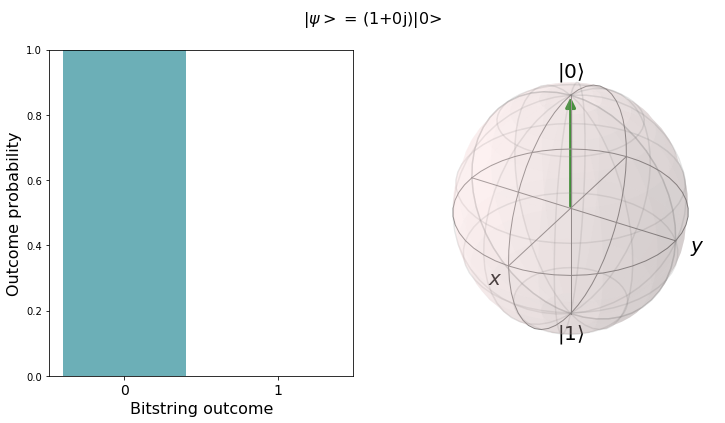

In [5]:
p = Program()
p += I(0)
wf = qvm.wavefunction(p)
plot_wf(wf)

### Run an $X$ gate to flip to $|1\rangle$

$$X|0\rangle = |1\rangle$$

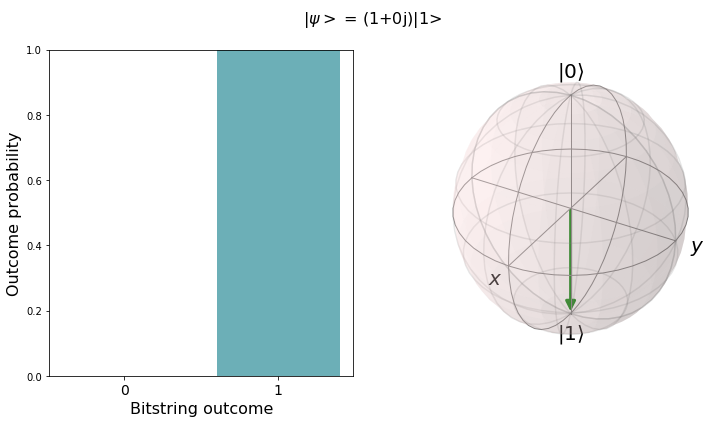

In [6]:
p = Program()
p += X(0)
wf = qvm.wavefunction(p)
plot_wf(wf)

### Create the 1Q superposition state $|+\rangle$ using the $H$ (Hadamard) gate

$$H|0\rangle = \dfrac{|0\rangle + |1\rangle}{\sqrt{2}} = |+\rangle$$

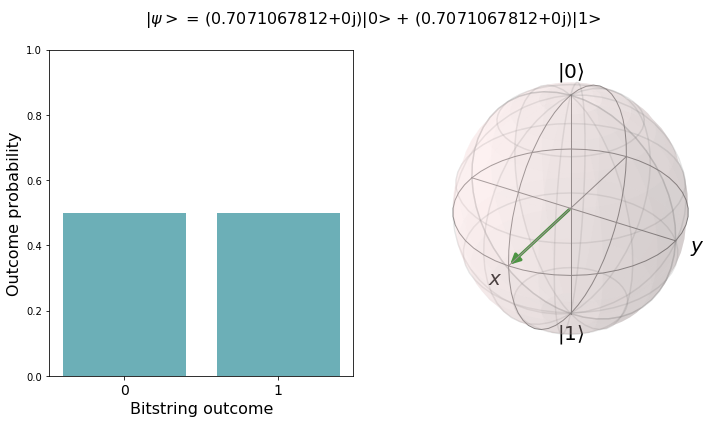

In [7]:
p = Program()
p += H(0)
wf = qvm.wavefunction(p)
plot_wf(wf)

### Create the 2Q computational basis state $|10\rangle$

$$(X \otimes I)|00\rangle = |10\rangle$$

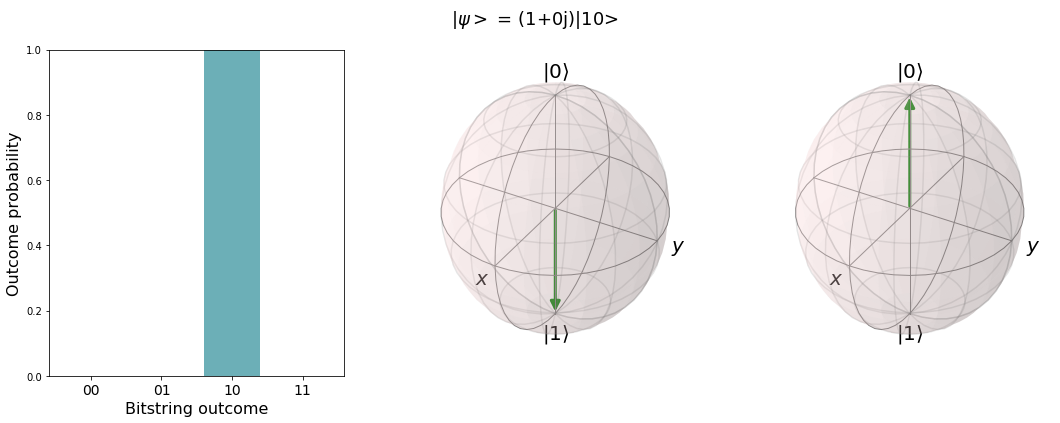

In [8]:
p = Program()
p += I(0)
p += X(1)
wf = qvm.wavefunction(p)

# this state is a product state
p0 = Program()
p0 += I(0)
wf0 = qvm.wavefunction(p0)
p1 = Program()
p1 += X(1)
wf1 = qvm.wavefunction(p1)

plot_wf(wf, wf0, wf1)

### Create the 2Q superposition state $|+,+\rangle$ using two Hadamard gates

$$(H \otimes H)|00\rangle = \left( \dfrac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \left( \dfrac{|0\rangle + |1\rangle}{\sqrt{2}}\right) = |+,+\rangle$$

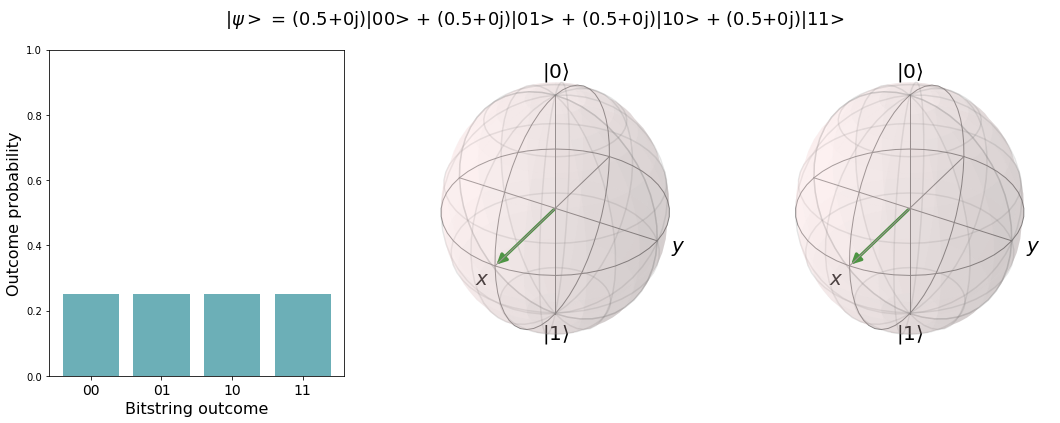

In [9]:
p = Program()
p += H(0)
p += H(1)
wf = qvm.wavefunction(p)

# this state is a product state
p0 = Program()
p0 += H(0)
wf0 = qvm.wavefunction(p0)
p1 = Program()
p1 += H(1)
wf1 = qvm.wavefunction(p1)

plot_wf(wf, wf0, wf1)

### Create the 2Q entangled (Bell) state $|\Phi^+\rangle$

Note that, because we are in an entangled state, we can no longer factor our state into the tensor product of two individual qubit states (called a "product state"), and therefore cannot plot two independent Bloch spheres as we did above.

$$\text{CNOT}_{0,1}(I \otimes H)|00\rangle = \text{CNOT}_{0,1}|0\rangle \otimes \left( \dfrac{|0\rangle + |1\rangle}{\sqrt{2}}\right) = \dfrac{|00\rangle + |11\rangle}{\sqrt{2}} = |\Phi^+\rangle$$

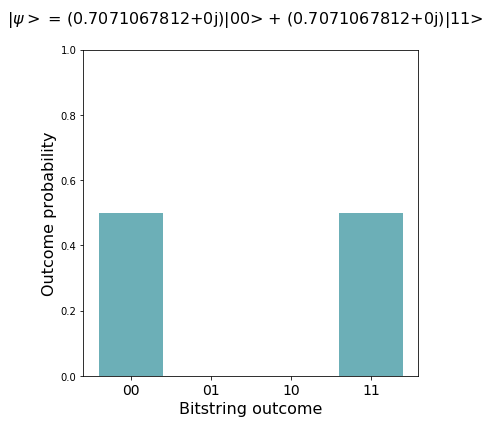

In [10]:
p = Program()
p += H(0)
p += CNOT(0, 1)
wf = qvm.wavefunction(p)
plot_wf(wf)

<a id='classical-logic'></a>

## Part II: Classical logic & function evaluation

In Computer Science, we learn about Boolean logic gates like `NOT`, `AND`, `OR`, and `XOR`. In quantum computing, we can implement these classical logic gates, but we must reimplement these gates in a way that respects the unitary requirements of quantum logic gates.

### Function for calculating the truth table of some circuit

The contents of the first half of this function are not particularly important to understand. However, the loop at the bottom introduces some new concepts that are important for running on the QVM. Because we are using the `run` method of the QVM now instead of the `wavefunction` method, we need to declare our readout memory "ro" and measure our output qubit into the readout register.

In the following code block, we take an existing `Program` and add a `DECLARE` statement to it. The first argument is the name of the block of memory ("ro"), and the second argument is the data type ("BIT"). There is an optional third argument for specifying the length of the block, but it defaults to 1 (which is what we want). This line looks different than the typical `+= INSTRUCTION` format because the return value of the `declare` method is important to us. This variable `ro` is then passed to the `MEASURE` instruction in the following code block.

```
ro = p.declare('ro', 'BIT')
```

In this code block we add a `MEASURE` instruction to the end of our `Program`. The first argument of the instruction is the qubit that we want to measure (in our case this is whatever qubit we declare to represent the "out" bit of our Boolean function). The second argument is the memory reference variable that corresponds to a particular readout register. Our readout memory is of length 1, and so we select the first (zero-indexed) address to use.

```
p += MEASURE(out, ro[0])
```

In [11]:
import itertools

gate_map = {'0': I, '1': X}

def calculate_truth_table(qvm: QVMConnection, circuit: Program, name: str, out: int, ancilla: int):
    if ancilla:
        qubits = circuit.get_qubits() - {ancilla}
    else:
        qubits = circuit.get_qubits()
    num_qubits_set = set(range(len(qubits)))
    if qubits != num_qubits_set:
        raise ValueError('Please index the qubits of your circuit starting at 0')
    
    bitstrings = itertools.product('01', repeat=len(qubits))
    print(f'\n{name}\n')
    print('in -> out\n---------')
    
    for bitstring in bitstrings:
        p = Program()
        ro = p.declare('ro', 'BIT')
        for idx, bit in enumerate(reversed(list(bitstring))):
            p += gate_map[bit](idx)
        p += circuit
        p += MEASURE(out, ro[0])
        result = qvm.run(p)
        print(f"{''.join(bitstring)} -> {result[0][0]}")

### Encoding Boolean functions of 1-bit domain in quantum circuits

$$x \in \{0,1\} \hspace{1cm} f(x) \rightarrow \{0,1\}$$

One-bit boolean functions represent the simplest classical logic we can implement on a quantum computer. There are four possible one-bit functions $f(x)$, and we will work through all of them.

### Balanced functions

$$\text{Balanced-}I : (0 \rightarrow 0,  1 \rightarrow 1)
\hspace{1 cm}
\text{Balanced-}X : (0 \rightarrow 1,  1 \rightarrow 0)$$

For the balanced 1-bit functions, it’s pretty easy to come up with a quantum circuit that works. If we use just an $I$ gate for Balanced-$I$ and just an $X$ gate for Balanced-$X$, we can produce a quantum circuit $U_f$ that maps $|x\rangle \rightarrow |f(x)\rangle$. Knowing the gate and and output, we can reproduce the input, which means our circuit satisfies the requirements of unitarity—it is length persevering and invertible.

### Constant functions

$$\text{Constant-}0 : (0 \rightarrow 0,  1 \rightarrow 0)
\hspace{1 cm}
\text{Constant-}1 : (0 \rightarrow 1,  1 \rightarrow 1)$$

However, coming up with the circuit for the constant functions seems less trivial. You can write down a matrix that maps the 0 state to the 0 state and the 1 state to the 0 state, but this matrix has some problems. It is not invertible (determinant 0) and it is not length preserving (superposition state changes length), and therefore it is not unitary. We can also see that it is not reversible simply from the truth table—knowing the output and the gate isn’t enough to get back to the input.

### Ancilla qubits

$$|0, x\rangle \rightarrow |f(x), x\rangle$$

In order to write this function as a quantum circuit, we need to introduce a new concept—the ancilla qubit. An ancilla qubit is an additional qubit used in a computation that we know the initial state of. Using an ancilla, we can produce a quantum circuit $U_f$ that maps $|0, x\rangle \rightarrow |f(x), x\rangle$. Now, we can come up with a unitary matrix (albeit a trivial one) that allows us to evaluate constant functions. For the Constant-$0$, we just simply do nothing to the ancilla, and its state encodes $f(x)$. And for the Constant-$1$, all we have to do is flip the ancilla with an $X$ gate, and we get $f(x)$ for all $x$.

In [12]:
one_bit_functions = """
DEFCIRCUIT BALANCED_I in out:
    CNOT in out

DEFCIRCUIT BALANCED_X in out:
    X out
    CNOT in out

DEFCIRCUIT CONSTANT_0 in out:
    I in
    I out

DEFCIRCUIT CONSTANT_1 in out:
    I in
    X out
"""

print('ONE-BIT FUNCTIONS\n=================')
for circuit in ['BALANCED_I 0 1', 'BALANCED_X 0 1', 'CONSTANT_0 0 1', 'CONSTANT_1 0 1']:
    p = Program(one_bit_functions)
    p += circuit
    calculate_truth_table(qvm=qvm, circuit=p, name=circuit.split(' ')[0], out=1, ancilla=1)

ONE-BIT FUNCTIONS

BALANCED_I

in -> out
---------
0 -> 0
1 -> 1

BALANCED_X

in -> out
---------
0 -> 1
1 -> 0

CONSTANT_0

in -> out
---------
0 -> 0
1 -> 0

CONSTANT_1

in -> out
---------
0 -> 1
1 -> 1


### The Quantum `XOR` gate

The boolean function `XOR` (for "exclusive or") takes in two bits $x$ and $y$ and returns 1 if and only if the values of the bits are different from one another. Otherwise, it returns 0. The operation is written as $x \oplus y$, and although it is a two-bit function, we can implement it as a quantum circuit without an ancilla, by simply using the $\text{CNOT}$ gate.

$$\textrm{CNOT}_{0,1}|y, x\rangle = |y \oplus x, x\rangle$$

**Note**: We are using `DEFCIRCUIT` below for consistency, but you could just as easily not use it and instead replace all instances of `QXOR` with `CNOT` for the same effect.

In [13]:
xor_circuit = """
DEFCIRCUIT QXOR x y:
    CNOT x y
"""

print('QUANTUM XOR\n===========')
xor = Program(xor_circuit)
xor += 'QXOR 0 1'
calculate_truth_table(qvm=qvm, circuit=xor, name='QXOR', out=1, ancilla=None)

QUANTUM XOR

QXOR

in -> out
---------
00 -> 0
01 -> 1
10 -> 1
11 -> 0


### Deutsch Oracle

In Deutsch's algorithm, you are given something called an oracle (referred to as $U_f$), which maps $|y, x\rangle \rightarrow |y \oplus f(x), x\rangle$, and the goal is to determine a global property of the function $f(x)$ with as few queries to the oracle as possible. We can combine the two concepts above (one-bit function evaluation with ancillas, and the `XOR` gate), to produce the four implementations of the Deutsch Oracle with one ancilla qubit.

$$U_f : |y, 0, x\rangle \rightarrow |y \oplus f(x), 0, x\rangle$$

In [14]:
deutsch_oracles_naive = """
DEFCIRCUIT DEUTSCH_BALANCED_I x y fx:
    CNOT x fx
    CNOT fx y
    CNOT x fx

DEFCIRCUIT DEUTSCH_BALANCED_X x y fx:
    X fx
    CNOT x fx
    CNOT fx y
    CNOT x fx
    X fx

DEFCIRCUIT DEUTSCH_CONSTANT_0 x y fx:
    I x
    I fx
    CNOT fx y

DEFCIRCUIT DEUTSCH_CONSTANT_1 x y fx:
    I x
    X fx
    CNOT fx y
    X fx  
"""

print('NAIVE DEUTSCH ORACLES\n=====================')
for circuit in ['DEUTSCH_BALANCED_I 0 1 2', 'DEUTSCH_BALANCED_X 0 1 2', 'DEUTSCH_CONSTANT_0 0 1 2', 'DEUTSCH_CONSTANT_1 0 1 2']:
    p = Program(deutsch_oracles_naive)
    p += circuit
    calculate_truth_table(qvm=qvm, circuit=p, name=circuit.split(' ')[0], out=1, ancilla=2)

NAIVE DEUTSCH ORACLES

DEUTSCH_BALANCED_I

in -> out
---------
00 -> 0
01 -> 1
10 -> 1
11 -> 0

DEUTSCH_BALANCED_X

in -> out
---------
00 -> 1
01 -> 0
10 -> 0
11 -> 1

DEUTSCH_CONSTANT_0

in -> out
---------
00 -> 0
01 -> 0
10 -> 1
11 -> 1

DEUTSCH_CONSTANT_1

in -> out
---------
00 -> 1
01 -> 1
10 -> 0
11 -> 0


### Optimized Deutsch Oracle

For pedagogical reasons, it is nice to separate out the three steps in the Deutsch Oracle—evaluate $f(x)$, calculate $y \oplus f(x)$, and then return the ancilla to $|0\rangle$—but in practice we always want to implement our circuits in as few gates as possible (this is especially important when running on a real, noisy quantum computer!). Below, we show how we can rewrite each of the four Deutsch Oracle implementations (which we call $U_f$) without the need for an ancilla qubit.

$$U_f : |y, x\rangle \rightarrow |y \oplus f(x), x\rangle$$

In [15]:
deutsch_oracles = """
DEFCIRCUIT DEUTSCH_BALANCED_I x y:
    CNOT x y

DEFCIRCUIT DEUTSCH_BALANCED_X x y:
    X x
    CNOT x y
    X x

DEFCIRCUIT DEUTSCH_CONSTANT_0 x y:
    I x
    I y

DEFCIRCUIT DEUTSCH_CONSTANT_1 x y:
    I x
    X y
"""

print('OPTIMIZED DEUTSCH ORACLES\n=========================')
for circuit in ['DEUTSCH_BALANCED_I 0 1', 'DEUTSCH_BALANCED_X 0 1', 'DEUTSCH_CONSTANT_0 0 1', 'DEUTSCH_CONSTANT_1 0 1']:
    p = Program(deutsch_oracles)
    p += circuit
    calculate_truth_table(qvm=qvm, circuit=p, name=circuit.split(' ')[0], out=1, ancilla=None)

OPTIMIZED DEUTSCH ORACLES

DEUTSCH_BALANCED_I

in -> out
---------
00 -> 0
01 -> 1
10 -> 1
11 -> 0

DEUTSCH_BALANCED_X

in -> out
---------
00 -> 1
01 -> 0
10 -> 0
11 -> 1

DEUTSCH_CONSTANT_0

in -> out
---------
00 -> 0
01 -> 0
10 -> 1
11 -> 1

DEUTSCH_CONSTANT_1

in -> out
---------
00 -> 1
01 -> 1
10 -> 0
11 -> 0


<a id='parallelism'></a>

## Part III: Quantum Parallelism

In the previous section, we showed that we could implement classical logic using quantum circuits. However, when using a computational basis state ($|0\rangle$ or $|1\rangle$), we don't do anything more interesting than a classical computer can do. If we instead feed a superposition state into one of these circuits, we can effectively evaluate a function $f(x)$ on multiple values of $x$ at once!

$$U_f : |0,+\rangle \rightarrow \dfrac{|f(0), 0\rangle + |f(1), 1\rangle}{\sqrt{2}}$$

$$U_f : |0,-\rangle \rightarrow \dfrac{|f(0), 0\rangle - |f(1), 1\rangle}{\sqrt{2}}$$

It is important to note, that although this quantum parallelism concept is interesting, we are unable to learn about both $f(0)$ and $f(1)$ when the states above are in that form. This is due to the fact that we can only extract one classical bit's worth of information from a quantum computer (of 1 qubit) when we measure it. But, as we will find in Deutsch's algorithm below, we can cleverly take advantage of quantum parallelism to do things that a classical computer cannot, even with the constraint that measurement yields only one classical bit.

### Run Balanced-$I$ on state $|0, +\rangle$

$$\text{CNOT}_{0,1}|0,+\rangle = \dfrac{|0, 0\rangle + |1, 1\rangle}{\sqrt{2}}$$

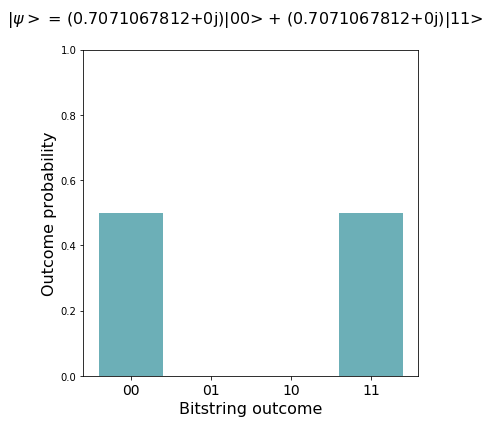

In [16]:
balanced_I = Program(one_bit_functions)
balanced_I += H(0)
balanced_I += 'BALANCED_I 0 1'
wf = qvm.wavefunction(balanced_I)
plot_wf(wf)

### Run Balanced-$I$ on state $|0, -\rangle$

$$\text{CNOT}_{0,1}|0,-\rangle = \dfrac{|0, 0\rangle - |1, 1\rangle}{\sqrt{2}}$$

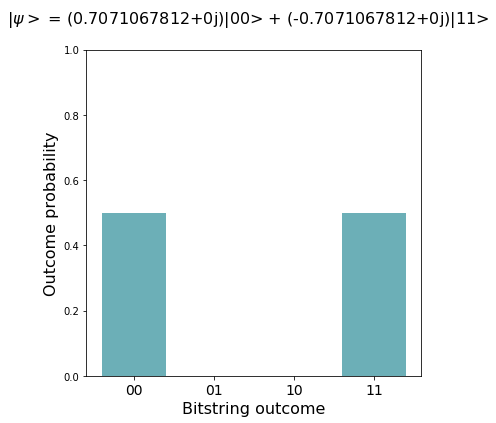

In [17]:
balanced_I = Program(one_bit_functions)
balanced_I += X(0)
balanced_I += H(0)
balanced_I += 'BALANCED_I 0 1'
wf = qvm.wavefunction(balanced_I)
plot_wf(wf)

### Run Balanced-$X$ on state $|0, +\rangle$

$$(I \otimes X)\text{CNOT}_{0,1}(I \otimes X)|0, +\rangle = \dfrac{|1, 0\rangle + |0, 1\rangle}{\sqrt{2}}$$

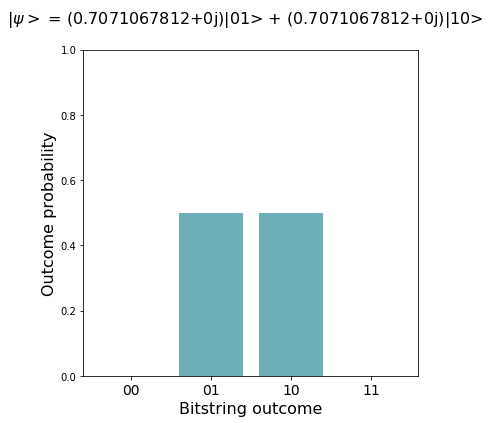

In [18]:
balanced_X = Program(one_bit_functions)
balanced_X += H(0)
balanced_X += 'BALANCED_X 0 1'
wf = qvm.wavefunction(balanced_X)
plot_wf(wf)

### Run Balanced-$X$ on state $|0, -\rangle$

$$(I \otimes X)\text{CNOT}_{0,1}(I \otimes X)|0, -\rangle = \dfrac{|1, 0\rangle - |0, 1\rangle}{\sqrt{2}}$$

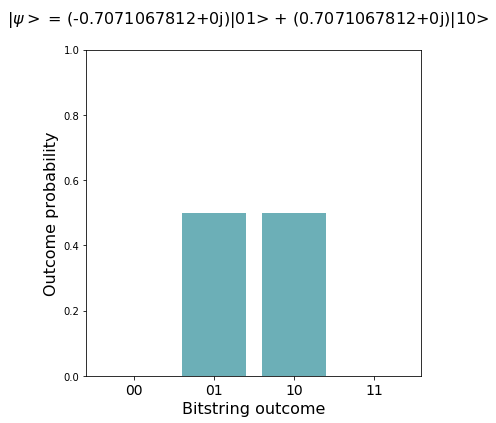

In [19]:
balanced_X = Program(one_bit_functions)
balanced_X += X(0)
balanced_X += H(0)
balanced_X += 'BALANCED_X 0 1'
wf = qvm.wavefunction(balanced_X)
plot_wf(wf)

<a id='deutsch'></a>

## Part IV: Deutsch's algorithm

**Goal**: Determine if a one-bit function $f(x)$ is *constant* or *balanced*. We show that we can do this with only one query to the Deutsch Oracle, which is impossible on a classical computer, which would require two queries to the Deutsch Oracle to determine this global property of $f(x)$.

As part of the algorithm, we are given a Deutsch Oracle and are unaware of which function $f(x)$ it implements. However, for the purposes of understanding exactly how the algorithm works, we will pick an instantiation of the oracle to use with the QVM. But, of course, the quantum speedup only makes sense if we don't know the contents of the oracle and instead treat it as a black box.

### Step 0: Initial state $|10\rangle$

$$|\psi_0\rangle = |10\rangle$$

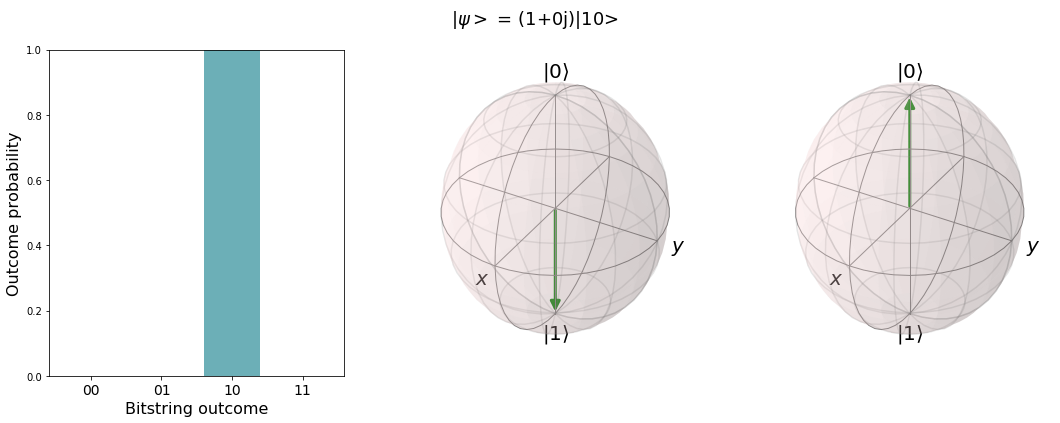

In [20]:
step0 = Program(deutsch_oracles)

step0 += [I(0), X(1)]
wf = qvm.wavefunction(step0)

# this is a product state
p0 = Program()
p0 += I(0)
wf0 = qvm.wavefunction(p0)
p1 = Program()
p1 += X(1)
wf1 = qvm.wavefunction(p1)

plot_wf(wf, wf0, wf1)

### Step 1: Prepare superpositions

We can't do anything interesting with computational basis states, so to take advantage of quantum parallelism we put our qubits in superposition states.

$$|\psi_1\rangle = (H \otimes H)|\psi_0\rangle = (H \otimes H)|10\rangle = \left( \dfrac{|0\rangle - |1\rangle}{\sqrt{2}}\right) \otimes \left( \dfrac{|0\rangle + |1\rangle}{\sqrt{2}}\right) = |-,+\rangle$$

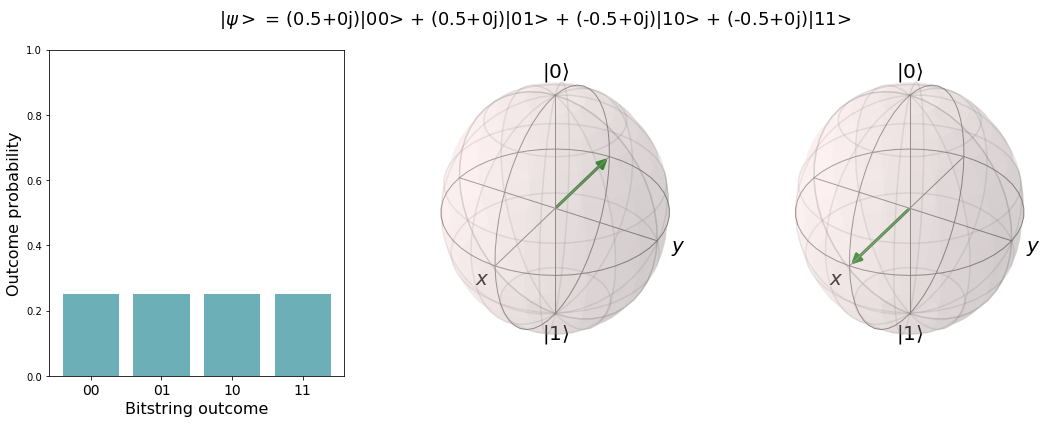

In [21]:
step1 = Program(H(0), H(1))
wf = qvm.wavefunction(step0 + step1)

# this is a product state still
p0 = Program(I(0), H(0))
wf0 = qvm.wavefunction(p0)
p1 = Program(X(0), H(0))
wf1 = qvm.wavefunction(p1)

plot_wf(wf, wf0, wf1)

### Step 2: Apply the Deutsch Oracle

We learned earlier that the action of the Deutsch Oracle on input state $|y,x\rangle$ is $U_f|y, x\rangle \rightarrow |y \oplus f(x), x\rangle$. So, what happens if we apply the Deutsch Oracle to the input state $|-,x\rangle$?

$$U_f|-, x\rangle \rightarrow |-\rangle \otimes (-1)^{f(x)}|x\rangle$$

We get a negative sign if $f(x) = 1$, and the state is unchanged if $f(x) = 0$. However, something interesting happens when we apply $U_f$ to the state $|-,+\rangle$, which is our state $|\psi_1\rangle$:

$$|\psi_2\rangle = U_f|\psi_1\rangle = U_f|-, +\rangle = |-\rangle \otimes \left( \dfrac{(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle}{\sqrt{2}}\right) =
\begin{cases}
   \pm |-\rangle \otimes \left( \dfrac{|0\rangle + |1\rangle}{\sqrt{2}}\right) = \pm |-,+\rangle \text{ if constant;}\\
   \pm |-\rangle \otimes \left( \dfrac{|0\rangle - |1\rangle}{\sqrt{2}}\right) = \pm |-,-\rangle \text{ if balanced.}
\end{cases}$$

If $f(x)$ is balanced, this has the effect of changing the relative phase between the $|0\rangle$ and $|1\rangle$ components of qubit 0's state, which flips it from $|+\rangle$ to $|-\rangle$. This is interesting, because the action of our oracle on the computational basis state $|y,x\rangle$ is to change the state of qubit 1 and leave qubit 0 alone. But, when our qubits are in superposition states, the balanced oracle actually changes the state of qubit 0, and leaves the state of qubit 1 alone.

Although we can work through the math without choosing an implementation of the oracle, we can't use the QVM unless we give it an actual circuit. So, we will use the Deutsch Oracle `DEFCIRCUIT`s we defined in the previous section, to see what happens next. You can comment out any of the four `step2` lines to experiment with different oracle instantations!

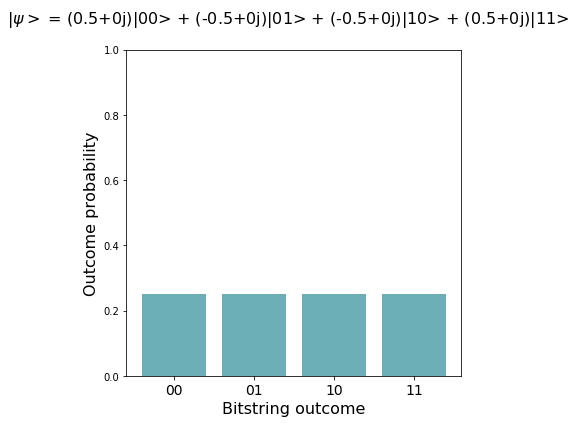

In [22]:
step2 = Program('DEUTSCH_BALANCED_I 0 1')
# step2 = Program('DEUTSCH_BALANCED_X 0 1')
# step2 = Program('DEUTSCH_CONSTANT_0 0 1')
# step2 = Program('DEUTSCH_CONSTANT_1 0 1')
wf = qvm.wavefunction(step0 + step1 + step2)
plot_wf(wf)

### Step 3: Return to 2Q computational basis states

We know that the outcome of step 3 is to produce one of two superposition product states, $|-, +\rangle$ or $|-, -\rangle$.

$$|\psi_3\rangle = (H \otimes H)|\psi_2\rangle = 
\begin{cases}
   \pm (H \otimes H)|-, +\rangle = \pm |10\rangle \text{ if constant;}\\
   \pm (H \otimes H)|-, -\rangle = \pm |11\rangle \text{ if balanced.}
\end{cases}$$

Thus, we are in two distinct 2Q computational basis states, dependent on the nature of $f(x)$. We could then measure the state of qubit 0 one time, and we would immediately know the answer of whether $f(x)$ is constant or balanced.

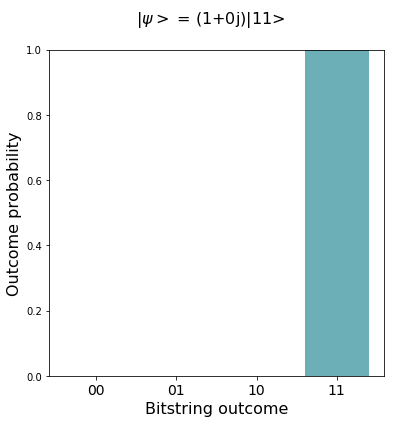

In [23]:
step3 = Program(H(1), H(0))
wf = qvm.wavefunction(step0 + step1 + step2 + step3)
plot_wf(wf)

### Conclusions

So, we were able to learn about a *global property* of the function $f(x)$ in just one query to the Deutsch Oracle, which is impossible on a classical computer. Although the problem statement for Deutsch's algorithm is a bit contrived, if you can suspend your judgment, you can imagine that we could take some of the non-classical concepts of this algorithm and apply them to a more complex scenario to actually produce an interesting quantum speedup. And, later in the course, you will do exactly this!

## Further Questions & Support

Join the Rigetti-Forest Slack workspace [here](https://join.slack.com/t/rigetti-forest/shared_invite/enQtNTUyNTE1ODg3MzE2LWExZWU5OTE4YTJhMmE2NGNjMThjOTM1MjlkYTA5ZmUxNTJlOTVmMWE0YjA3Y2M2YmQzNTZhNTBlMTYyODRjMzA) and feel free to reach out to me (@peter) with any questions!

## Time to run on the QPU!

If we have time left, we'll log into the Rigetti lab and try to run Deutsch's algortithm on a real quantum processor ([QPU](https://www.rigetti.com/qpu)) using our Quantum Cloud Services ([QCS](https://www.rigetti.com/qcs)) platform! Rigetti has allocated some QCS credits for this course, so for your final projects you will be able to run on the QPU as well, if you so choose.